In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# Volatility Smirk:

Option Data from OptionMetrics, Stock Price Data from CRSP.

Date: 2021/01/01~2021/12/31

### Option Filters:

    time to maturity: 30~90
    OI > 0
    best bid > 0
    IV: Non Missing
    BA Spread < 0.5*mean(Bid, Ask)
    abs(ln(moneyness)) < 0.1

In [2]:
option = pd.read_csv('option data for vol spread.csv')
option['strike'] = option['strike_price']/1000

#BA Spread < 0.5*mean(Bid, Ask)
option['BA_Spread'] = (option['best_offer'] - option['best_bid'])/(0.5*(option['best_offer'] + option['best_bid']))
option = option[option['BA_Spread'] <= 1]

option = option[['date', 'ticker', 'cp_flag', 'strike', 'impl_volatility']]
option

,date,ticker,cp_flag,strike,impl_volatility
0,2021-01-04,XLB,C,68.0,0.291553
1,2021-01-04,XLB,C,72.0,0.249517
2,2021-01-04,XLB,C,73.5,0.251734
3,2021-01-04,XLB,C,74.0,0.238924
4,2021-01-04,XLB,C,74.5,0.234832
...,...,...,...,...,...
332109,2021-12-31,XLC,P,80.0,0.145249
332110,2021-12-31,XLC,P,81.0,0.139425
332111,2021-12-31,XLC,P,82.0,0.135864
332112,2021-12-31,XLC,P,83.0,0.116889


In [3]:
stock = pd.read_csv('stock data for vol spread.csv')
stock.rename(columns = {'Ticker':'ticker', 'DlyCalDt':'date', 'DlyPrc':'price'}, inplace = True)
stock = stock[['date', 'ticker', 'price']]
stock

,date,ticker,price
0,2021-01-04,XLRE,35.38
1,2021-01-04,XLC,66.48
2,2021-01-04,XLB,71.70
3,2021-01-04,XLP,66.72
4,2021-01-04,XLY,159.42
...,...,...,...
2515,2021-12-31,XLE,55.50
2516,2021-12-31,XLF,39.05
2517,2021-12-31,XLI,105.81
2518,2021-12-31,XLK,173.87


### Merge datas and calculate abs(ln(moneyness))

In [4]:
data = pd.merge(option, stock, on = ['date', 'ticker'])

#abs(ln(moneyness)) < 0.1
data['filter'] = abs(np.log(data['strike']/data['price']))
data = data[data['filter'] < 0.1]

data

,date,ticker,cp_flag,strike,impl_volatility,price,filter
0,2021-01-04,XLB,C,68.0,0.291553,71.70,0.052983
1,2021-01-04,XLB,C,72.0,0.249517,71.70,0.004175
2,2021-01-04,XLB,C,73.5,0.251734,71.70,0.024795
3,2021-01-04,XLB,C,74.0,0.238924,71.70,0.031574
4,2021-01-04,XLB,C,74.5,0.234832,71.70,0.038308
...,...,...,...,...,...,...,...
313451,2021-12-31,XLC,P,80.0,0.145249,77.68,0.029429
313452,2021-12-31,XLC,P,81.0,0.139425,77.68,0.041851
313453,2021-12-31,XLC,P,82.0,0.135864,77.68,0.054121
313454,2021-12-31,XLC,P,83.0,0.116889,77.68,0.066243


### IVol: 不分C/P 計算平均IV

In [5]:
IVol = data.groupby(['date', 'ticker']).agg({'impl_volatility':'mean'}).reset_index()
IVol.rename(columns = {'impl_volatility':'IVol'}, inplace = True)
IVol

,date,ticker,IVol
0,2021-01-04,XLB,0.256761
1,2021-01-04,XLC,0.270642
2,2021-01-04,XLE,0.401114
3,2021-01-04,XLF,0.258929
4,2021-01-04,XLI,0.260642
...,...,...,...
2510,2021-12-31,XLK,0.213214
2511,2021-12-31,XLP,0.134323
2512,2021-12-31,XLRE,0.176939
2513,2021-12-31,XLU,0.154877


### CVol/PVol: 只看Call/Put

In [6]:
call = data[data['cp_flag'] == 'C']
CVol = call.groupby(['date', 'ticker']).agg({'impl_volatility':'mean'}).reset_index()
CVol.rename(columns = {'impl_volatility':'CVol'}, inplace = True)
CVol

,date,ticker,CVol
0,2021-01-04,XLB,0.249600
1,2021-01-04,XLC,0.264585
2,2021-01-04,XLE,0.407119
3,2021-01-04,XLF,0.262210
4,2021-01-04,XLI,0.260105
...,...,...,...
2510,2021-12-31,XLK,0.208724
2511,2021-12-31,XLP,0.132603
2512,2021-12-31,XLRE,0.180909
2513,2021-12-31,XLU,0.151446


In [7]:
put = data[data['cp_flag'] == 'P']
PVol = put.groupby(['date', 'ticker']).agg({'impl_volatility':'mean'}).reset_index()
PVol.rename(columns = {'impl_volatility':'PVol'}, inplace = True)
PVol

,date,ticker,PVol
0,2021-01-04,XLB,0.265008
1,2021-01-04,XLC,0.278718
2,2021-01-04,XLE,0.395277
3,2021-01-04,XLF,0.255956
4,2021-01-04,XLI,0.261245
...,...,...,...
2508,2021-12-31,XLK,0.218266
2509,2021-12-31,XLP,0.136259
2510,2021-12-31,XLRE,0.172968
2511,2021-12-31,XLU,0.159244


# 計算RVol需要更早的報酬率資料

In [8]:
stock_for_RVol = pd.read_csv('stock data for RVol.csv')
stock_for_RVol.rename(columns = {'Ticker':'ticker', 'DlyCalDt':'date', 'DlyRet':'ret'}, inplace = True)
stock_for_RVol.sort_values(['date', 'ticker'], inplace = True)

# 計算RVol: 使用過往20交易日（一個月）的daily return計算
window_size = 20
stock_for_RVol['RVol'] = stock_for_RVol.groupby('ticker')['ret'].rolling(window=window_size).std().reset_index(0, drop=True)

# 波動率年化
stock_for_RVol['RVol'] = stock_for_RVol['RVol'] * np.sqrt(252)
stock_for_RVol.dropna(inplace = True)
RVol = stock_for_RVol[['date', 'ticker', 'RVol']]
RVol

,date,ticker,RVol
192,2020-11-30,XLB,0.272958
191,2020-11-30,XLC,0.200708
195,2020-11-30,XLE,0.718702
196,2020-11-30,XLF,0.371134
197,2020-11-30,XLI,0.249982
...,...,...,...
2938,2021-12-31,XLK,0.273293
2933,2021-12-31,XLP,0.126675
2930,2021-12-31,XLRE,0.146493
2939,2021-12-31,XLU,0.115241


# Merge RVol, IVol, CVol, PVol

In [9]:
df1 = RVol.copy()
df2 = IVol.copy()
df3 = CVol.copy()
df4 = PVol.copy()

# 將四個資料框按照 ['date', 'ticker'] 合併
df = pd.merge(df1, df2, on=['date', 'ticker'], how='outer')
df = pd.merge(df, df3, on=['date', 'ticker'], how='outer')
df = pd.merge(df, df4, on=['date', 'ticker'], how='outer')

del df1 ,df2 ,df3 ,df4
df.dropna(inplace = True)
df['RV-IV'] = df['RVol'] - df['IVol']
df['CV-PV'] = df['CVol'] - df['PVol']
df = df.copy().merge(stock_for_RVol[['date', 'ticker', 'ret']], on = ['date', 'ticker'], how = 'inner')
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df

,date,ticker,RVol,IVol,CVol,PVol,RV-IV,CV-PV,ret
0,2021-01-04,XLB,0.145570,0.256761,0.249600,0.265008,-0.111191,-0.015408,-0.009532
1,2021-01-04,XLC,0.123610,0.270642,0.264585,0.278718,-0.147032,-0.014133,-0.014819
2,2021-01-04,XLE,0.332229,0.401114,0.407119,0.395277,-0.068885,0.011842,0.001583
3,2021-01-04,XLF,0.151849,0.258929,0.262210,0.255956,-0.107080,0.006254,-0.013569
4,2021-01-04,XLI,0.140359,0.260642,0.260105,0.261245,-0.120283,-0.001141,-0.024167
...,...,...,...,...,...,...,...,...,...
2508,2021-12-31,XLK,0.273293,0.213214,0.208724,0.218266,0.060078,-0.009542,-0.004865
2509,2021-12-31,XLP,0.126675,0.134323,0.132603,0.136259,-0.007649,-0.003656,0.006789
2510,2021-12-31,XLRE,0.146493,0.176939,0.180909,0.172968,-0.030445,0.007941,0.002128
2511,2021-12-31,XLU,0.115241,0.154877,0.151446,0.159244,-0.039636,-0.007798,0.003505


## BOX Plot

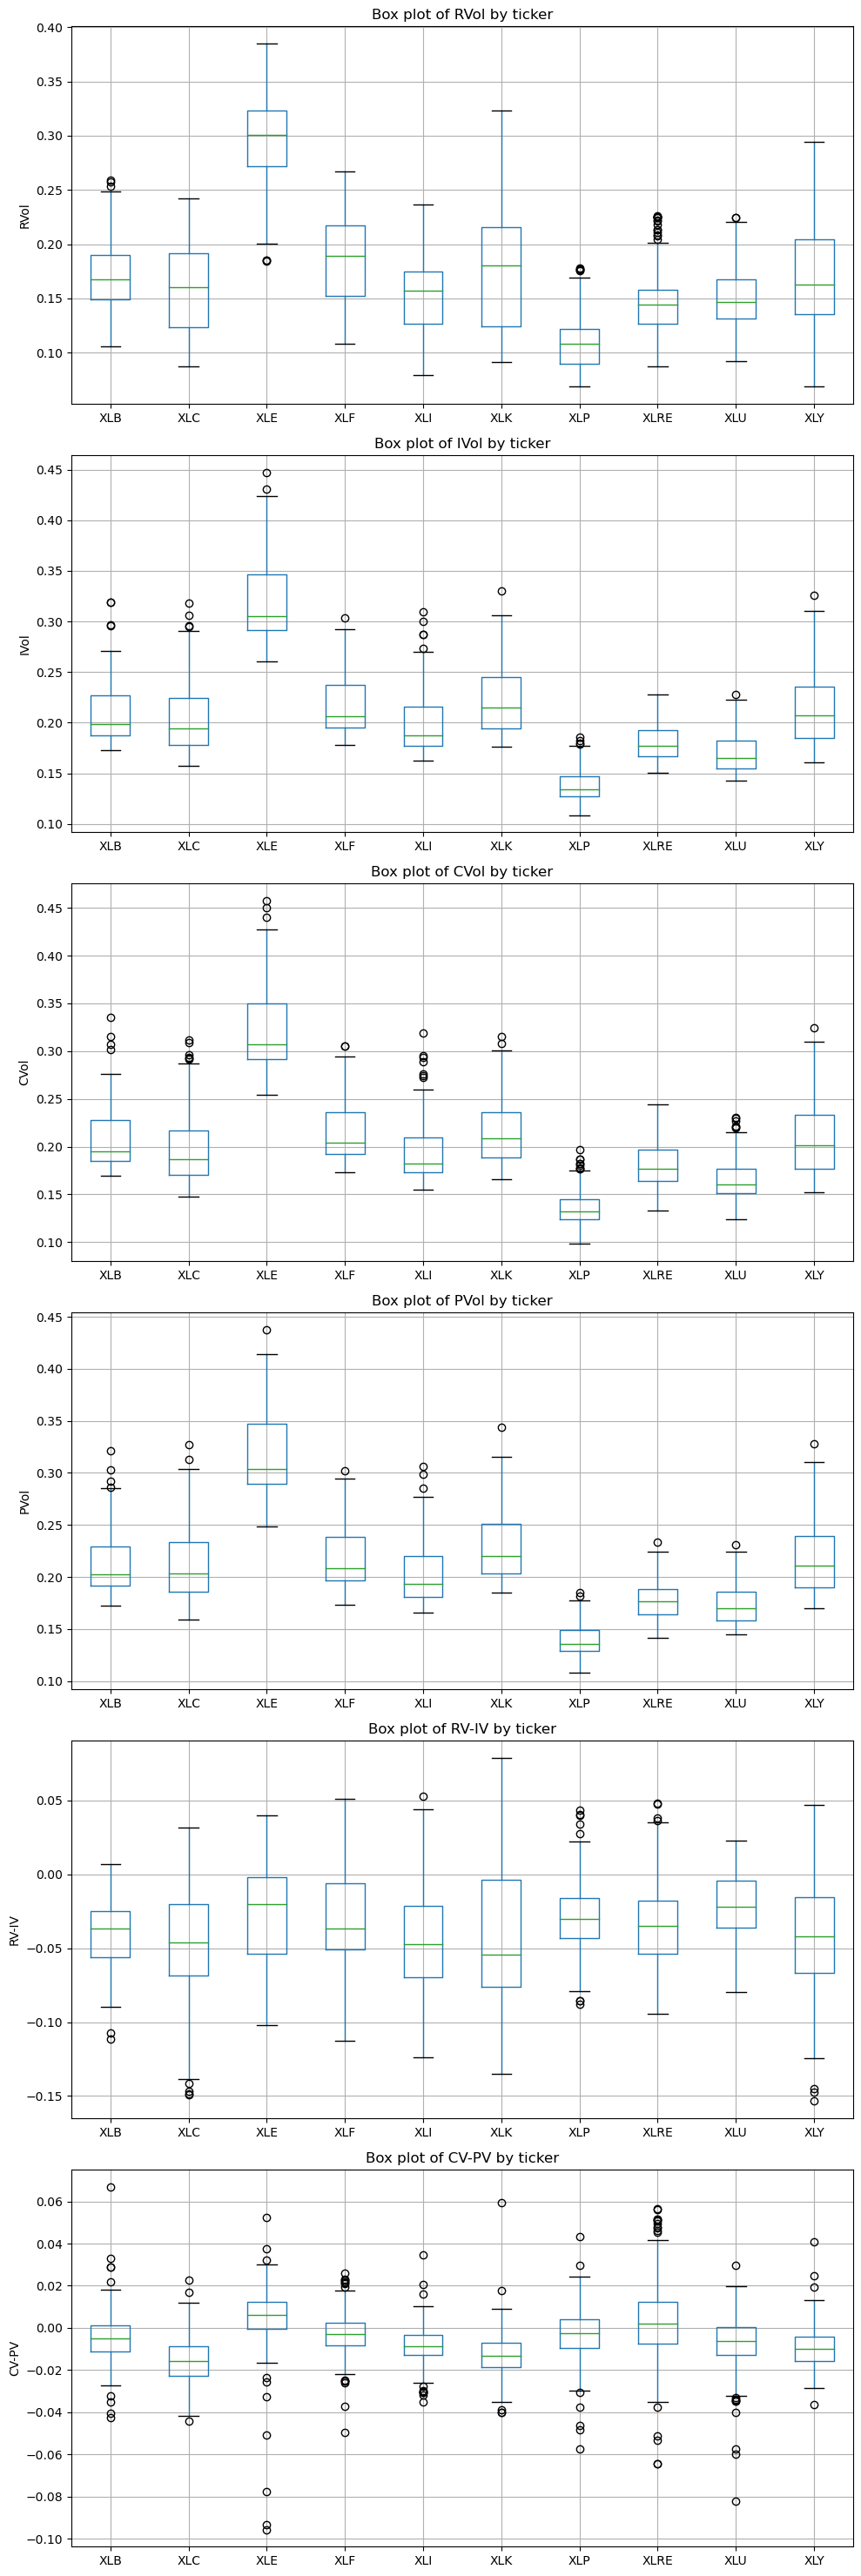

In [43]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(10, 30))

df.boxplot(column='RVol', by='ticker', ax=axes[0])
df.boxplot(column='IVol', by='ticker', ax=axes[1])
df.boxplot(column='CVol', by='ticker', ax=axes[2])
df.boxplot(column='PVol', by='ticker', ax=axes[3])
df.boxplot(column='RV-IV', by='ticker', ax=axes[4])
df.boxplot(column='CV-PV', by='ticker', ax=axes[5])


axes[0].set_title('Box plot of RVol by ticker')
axes[0].set_xlabel('')
axes[0].set_ylabel('RVol')

axes[1].set_title('Box plot of IVol by ticker')
axes[1].set_xlabel('')
axes[1].set_ylabel('IVol')

axes[2].set_title('Box plot of CVol by ticker')
axes[2].set_xlabel('')
axes[2].set_ylabel('CVol')

axes[3].set_title('Box plot of PVol by ticker')
axes[3].set_xlabel('')
axes[3].set_ylabel('PVol')

axes[4].set_title('Box plot of RV-IV by ticker')
axes[4].set_xlabel('')
axes[4].set_ylabel('RV-IV')

axes[5].set_title('Box plot of CV-PV by ticker')
axes[5].set_xlabel('')
axes[5].set_ylabel('CV-PV')

plt.tight_layout()


plt.suptitle('')
plt.show()

## 檢視 Volatility Spread 與報酬率的相關性：
#### RI_Spread: Realized Vol - Implied Vol 數值越高，代表 IV 低，投資人認為該資產未來風險不高，對其要求報酬率下降，故 RI_Spread 與 ret 的相關性應為負
#### CP_Spread: Call Implied Vol - Put Implied Vol 數值越高，表示市場看多標的資產，故 CP_Spread 與 ret 的相關性應為正

In [44]:
grouped = df.groupby('ticker')

for s in range(15):
    corr_df = pd.DataFrame(columns=['ticker', 'corr_RI_spread_ret', 'corr_CP_spread_ret'])
    for ticker, group in grouped:
        corr_RI_spread_ret = group['RV-IV'].corr(group['ret'].shift(s))
        corr_CP_spread_ret = group['CV-PV'].corr(group['ret'].shift(s))
        corr_df = corr_df.append({'ticker': ticker, 'corr_RI_spread_ret': corr_RI_spread_ret, 'corr_CP_spread_ret': corr_CP_spread_ret}, ignore_index=True)

    # 顯示結果
    print(f'相差日數:{s} \n', corr_df, '\n')

相差日數:0 
   ticker  corr_RI_spread_ret  corr_CP_spread_ret
0    XLB            0.251554           -0.146490
1    XLC            0.175762           -0.177047
2    XLE            0.065400            0.005992
3    XLF            0.221269           -0.087956
4    XLI            0.179523           -0.105611
5    XLK            0.181098           -0.157659
6    XLP            0.188580           -0.106749
7   XLRE            0.210665           -0.195678
8    XLU            0.104311           -0.137992
9    XLY            0.121223           -0.150328 

相差日數:1 
   ticker  corr_RI_spread_ret  corr_CP_spread_ret
0    XLB            0.198347           -0.110498
1    XLC            0.139765           -0.107480
2    XLE            0.027536            0.159478
3    XLF            0.146081            0.037318
4    XLI            0.129450           -0.018868
5    XLK            0.111847           -0.109958
6    XLP            0.196049           -0.168887
7   XLRE            0.193650           -0.022947


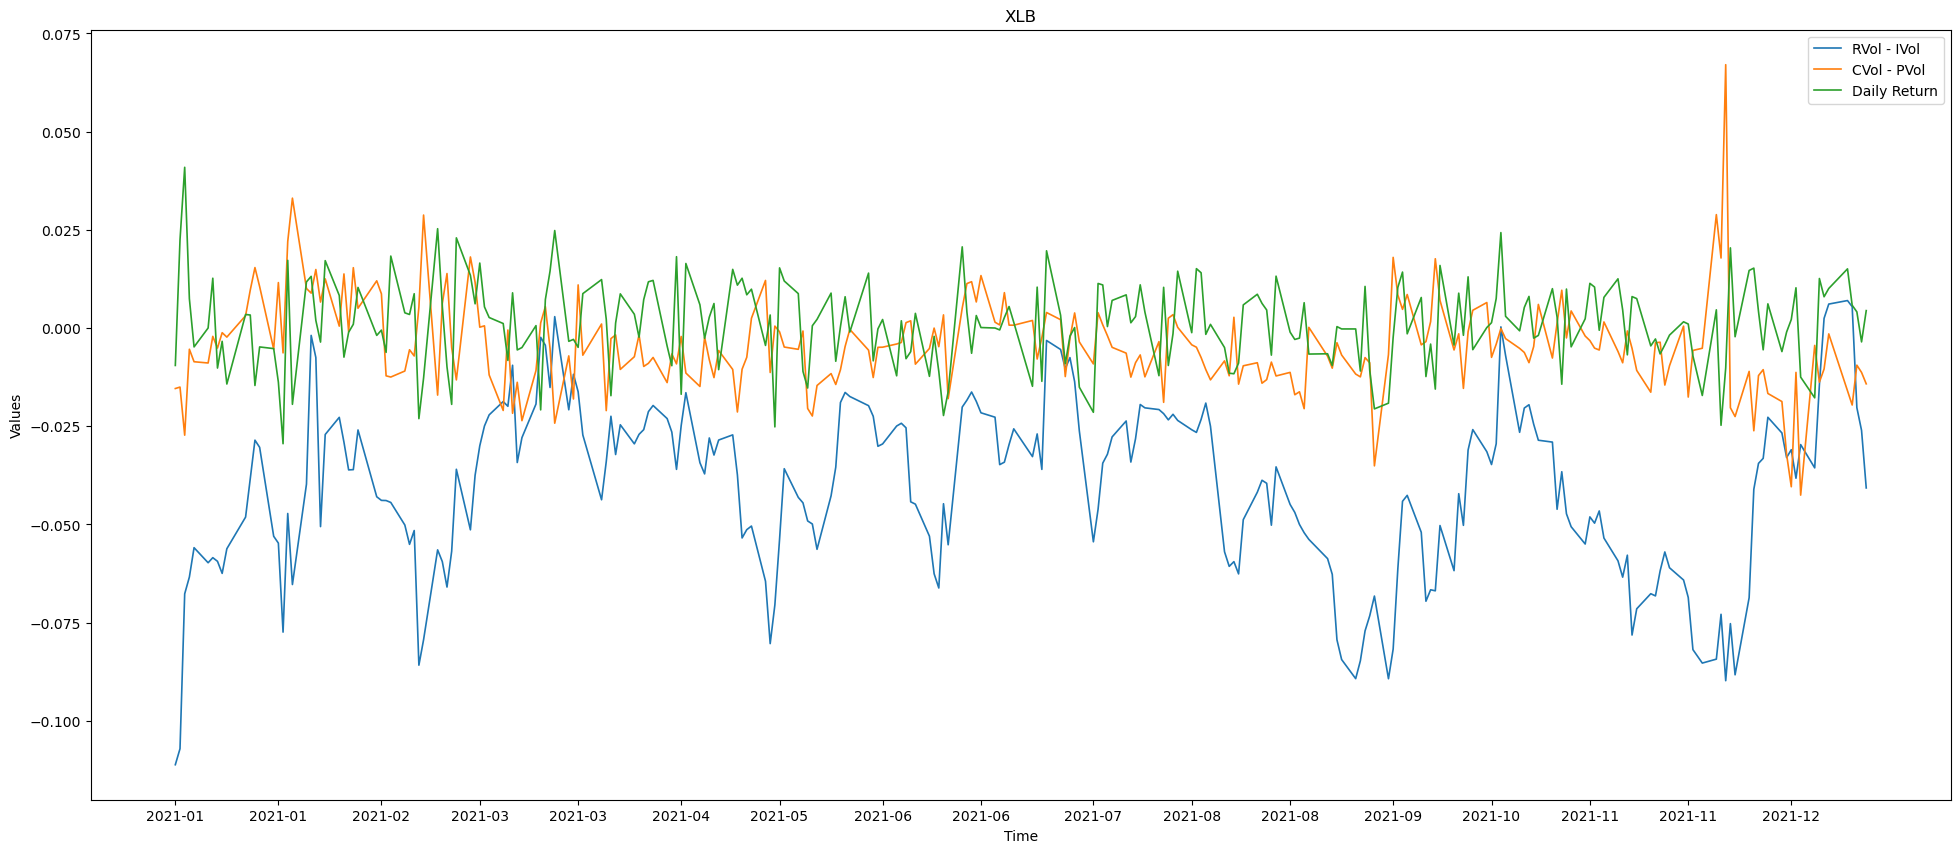

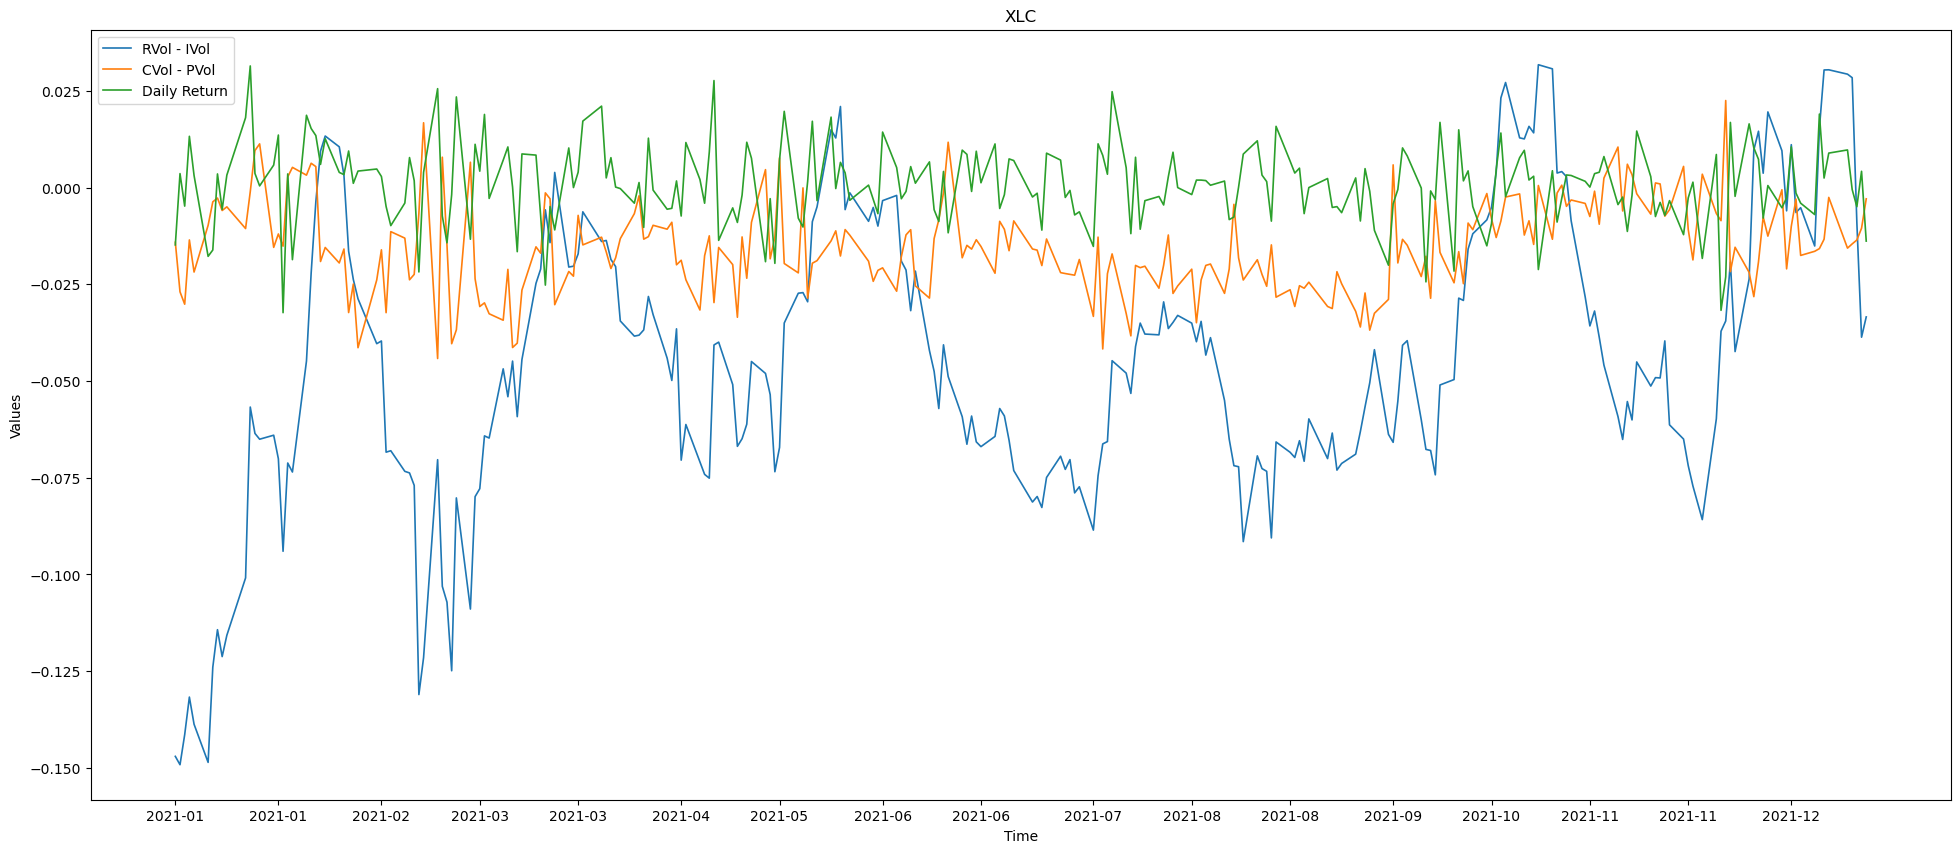

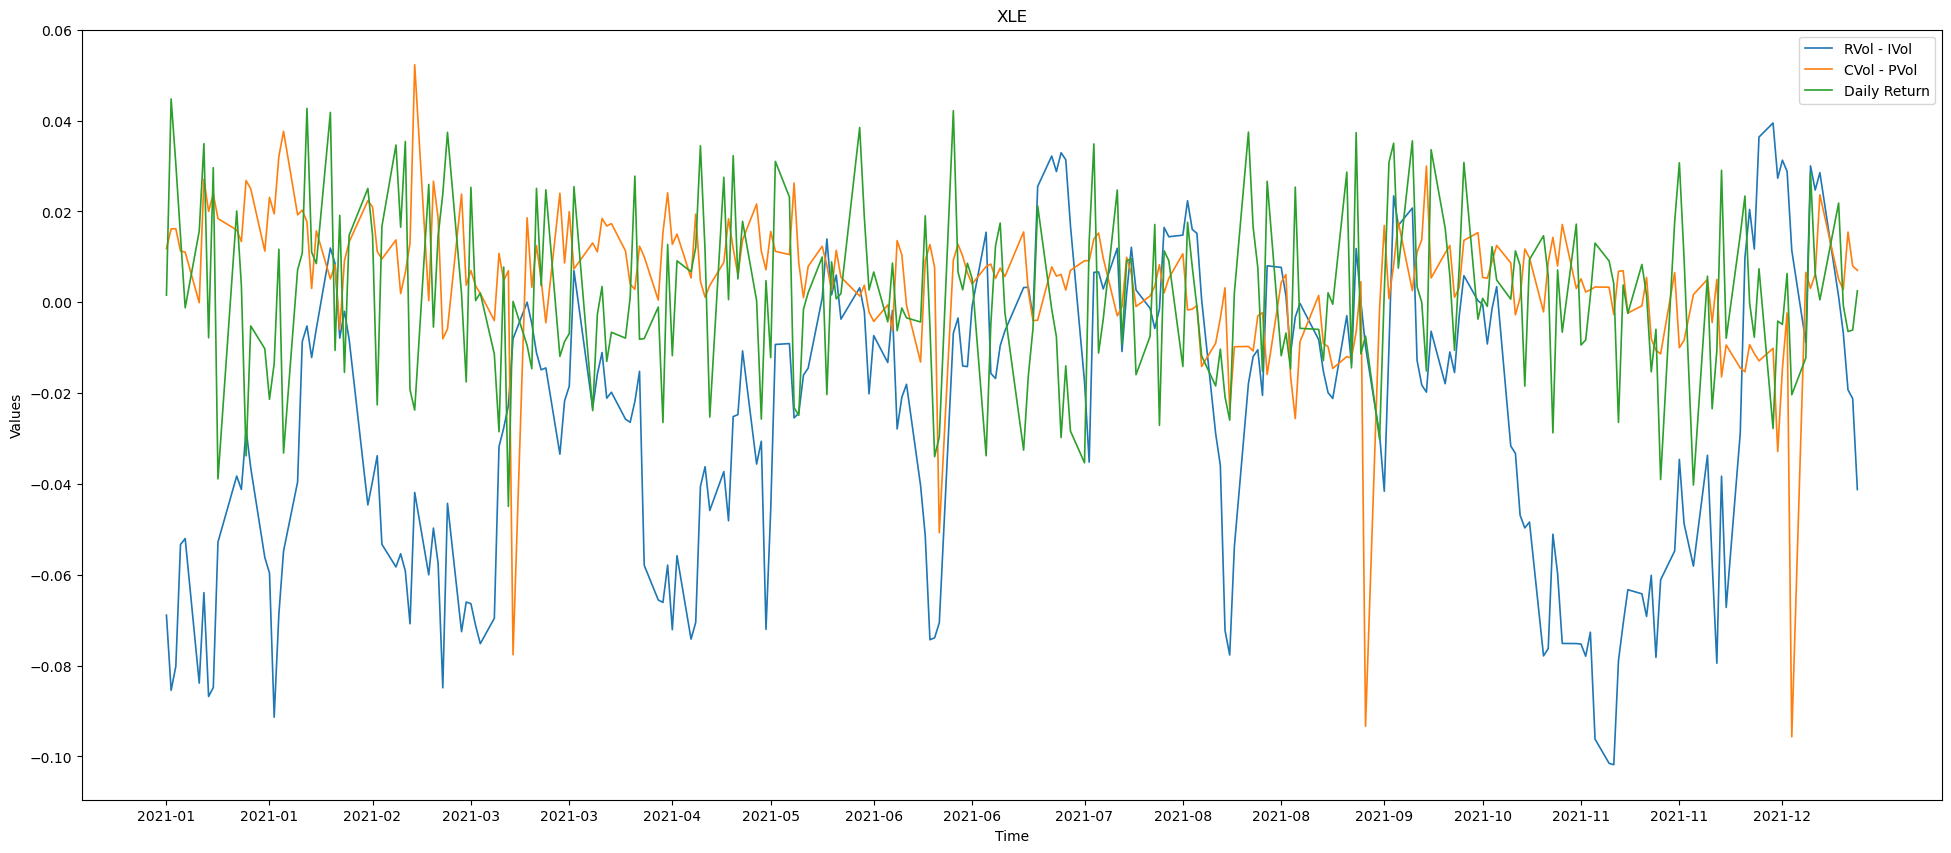

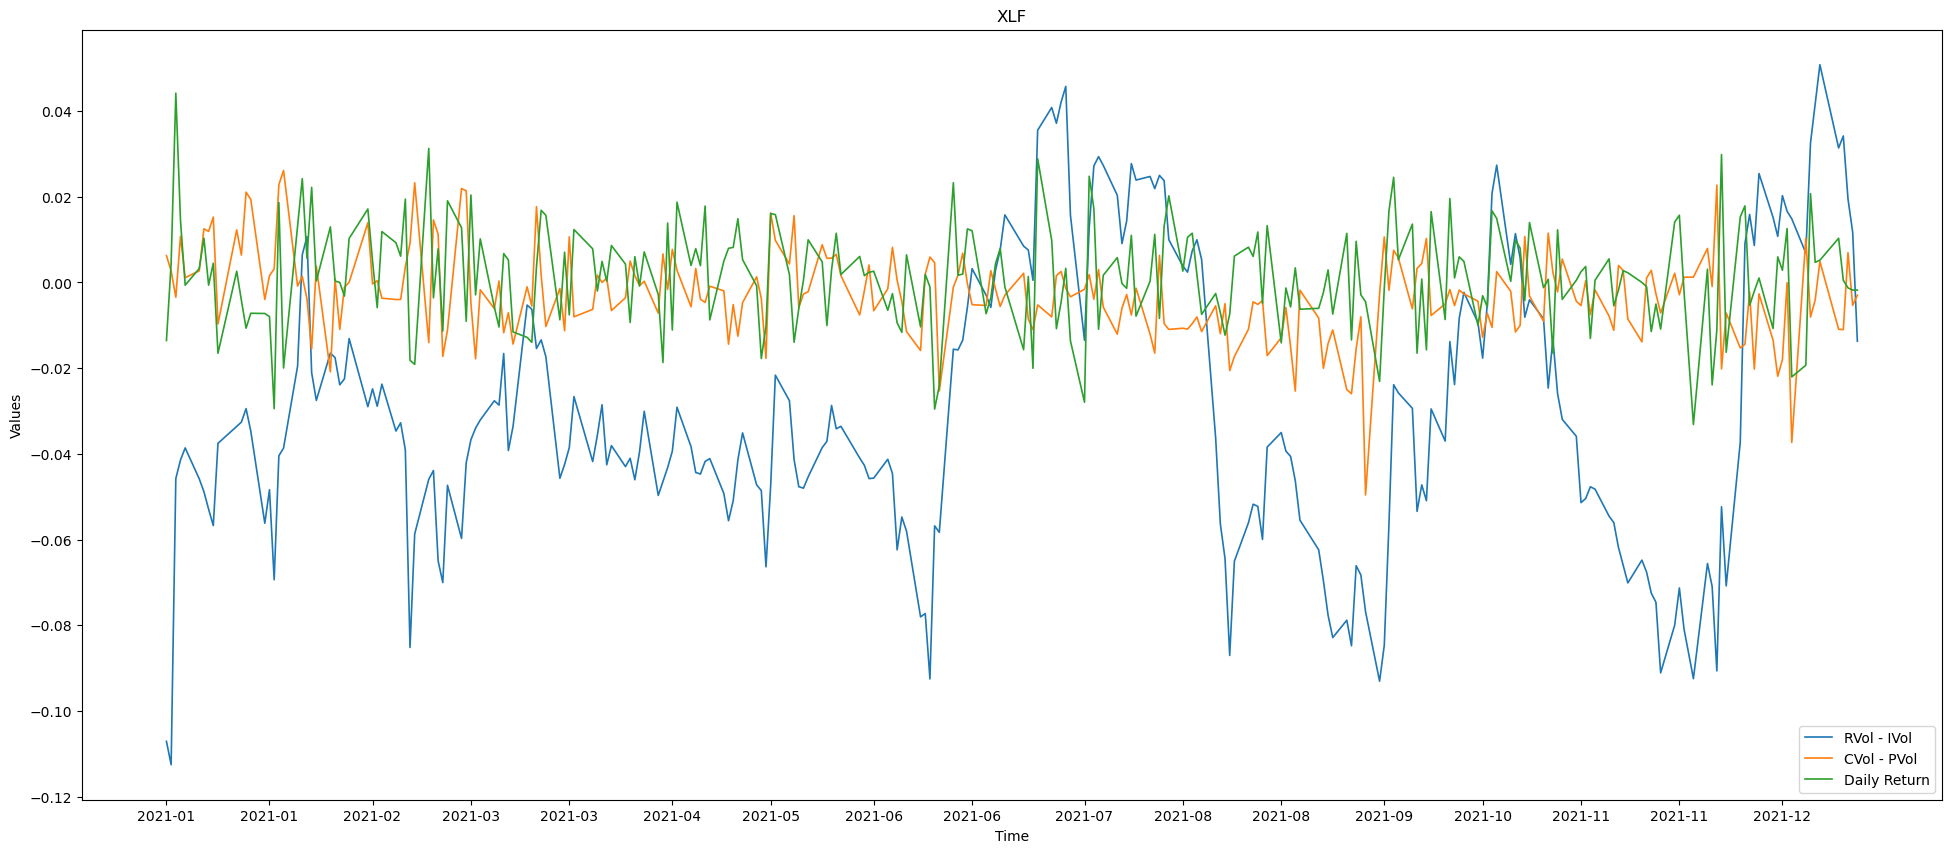

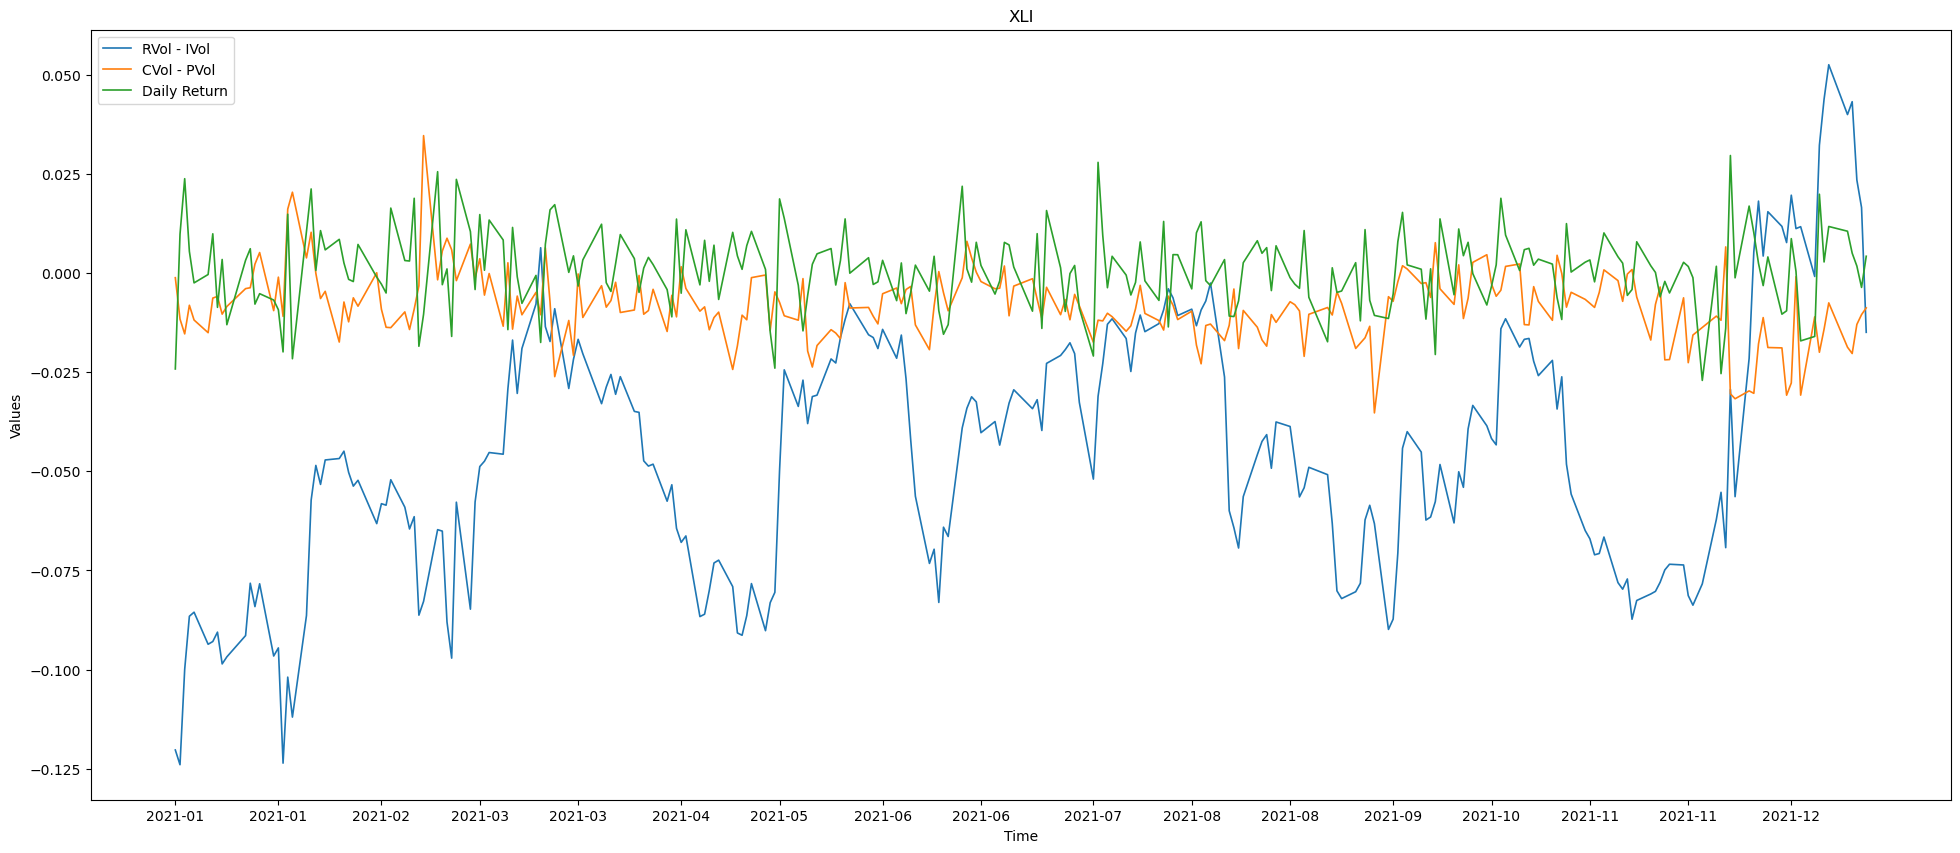

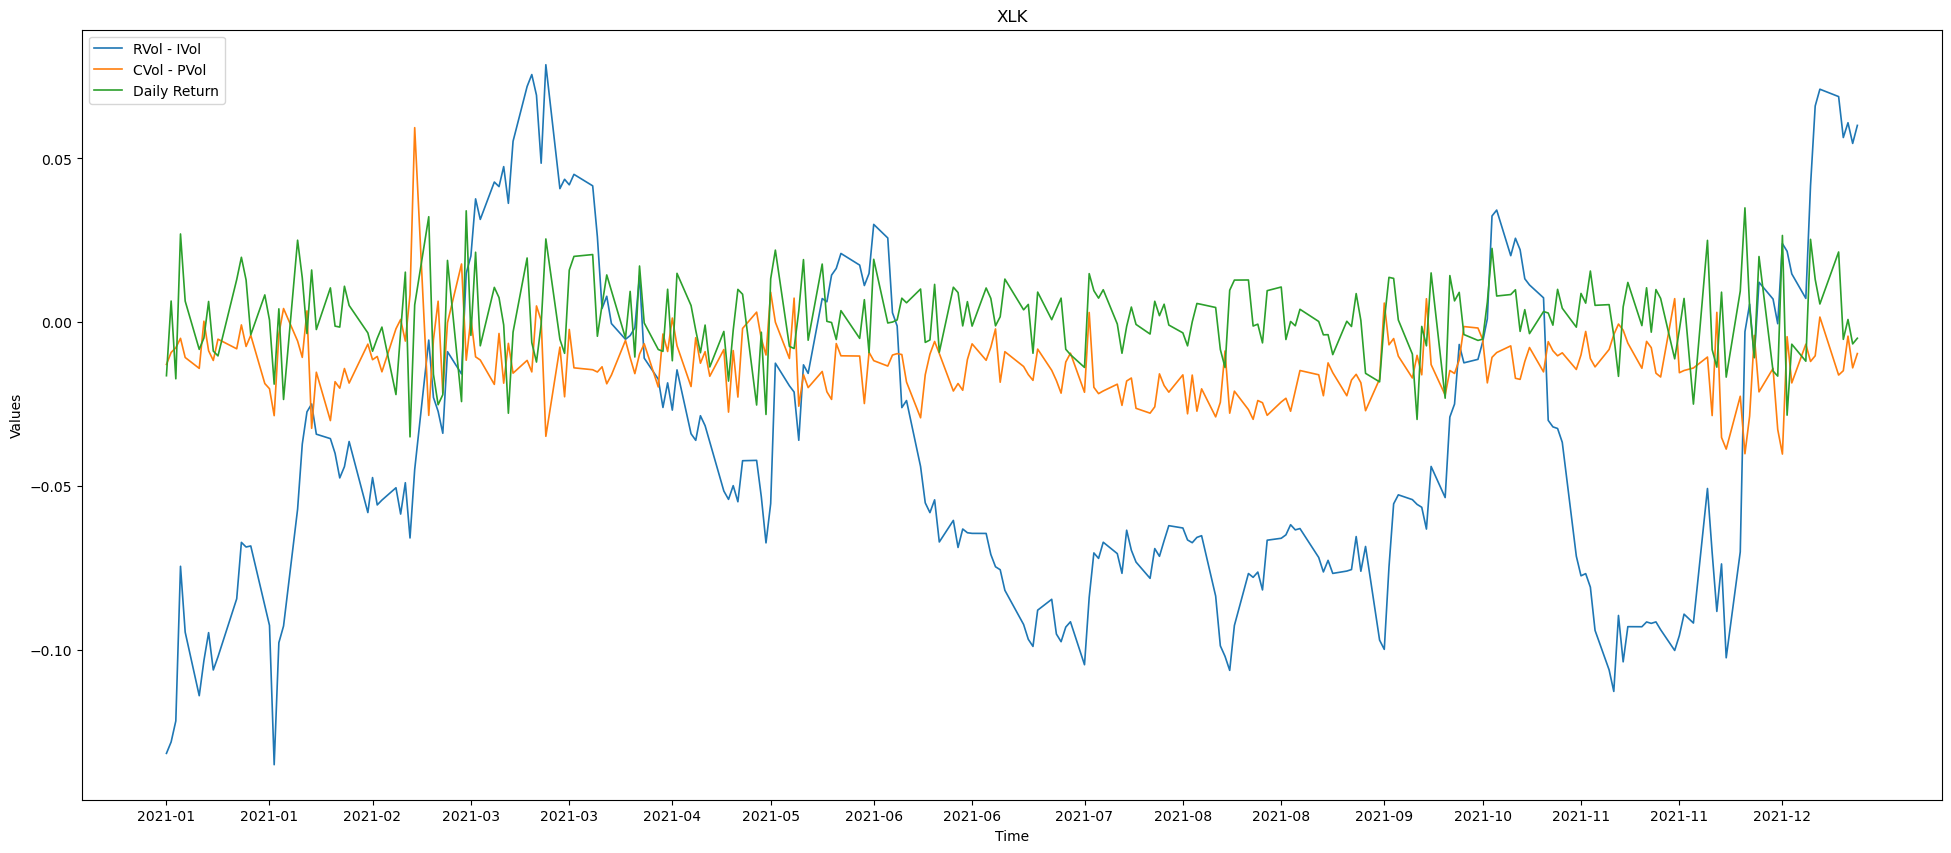

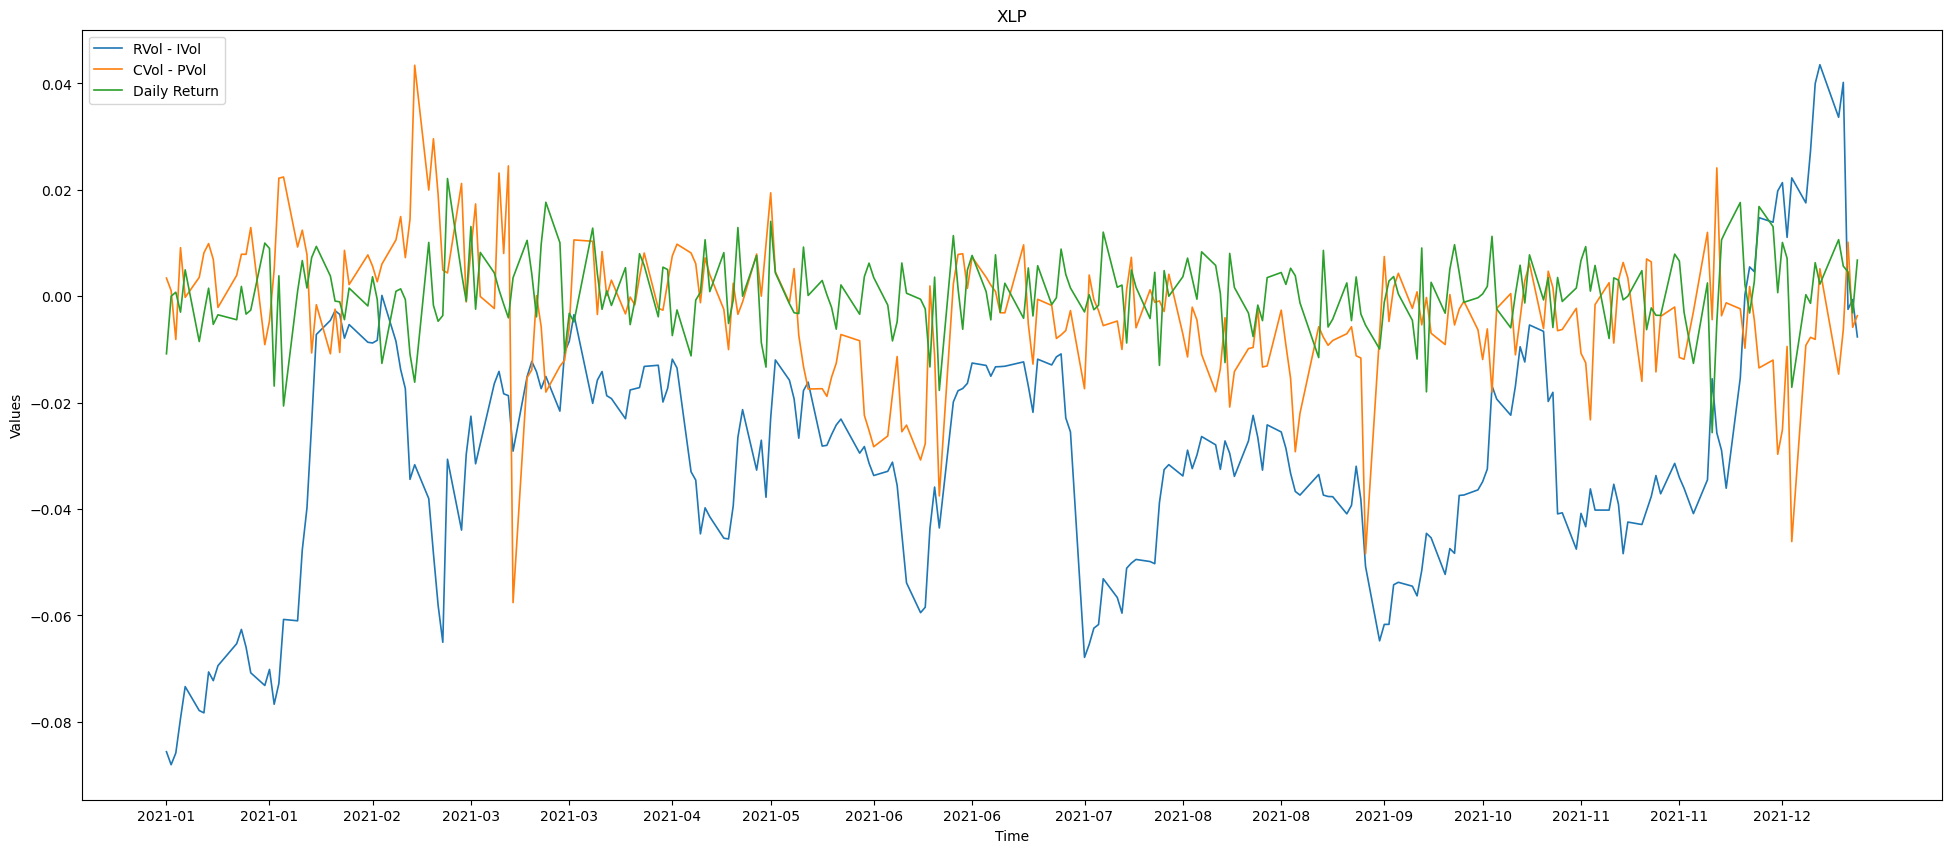

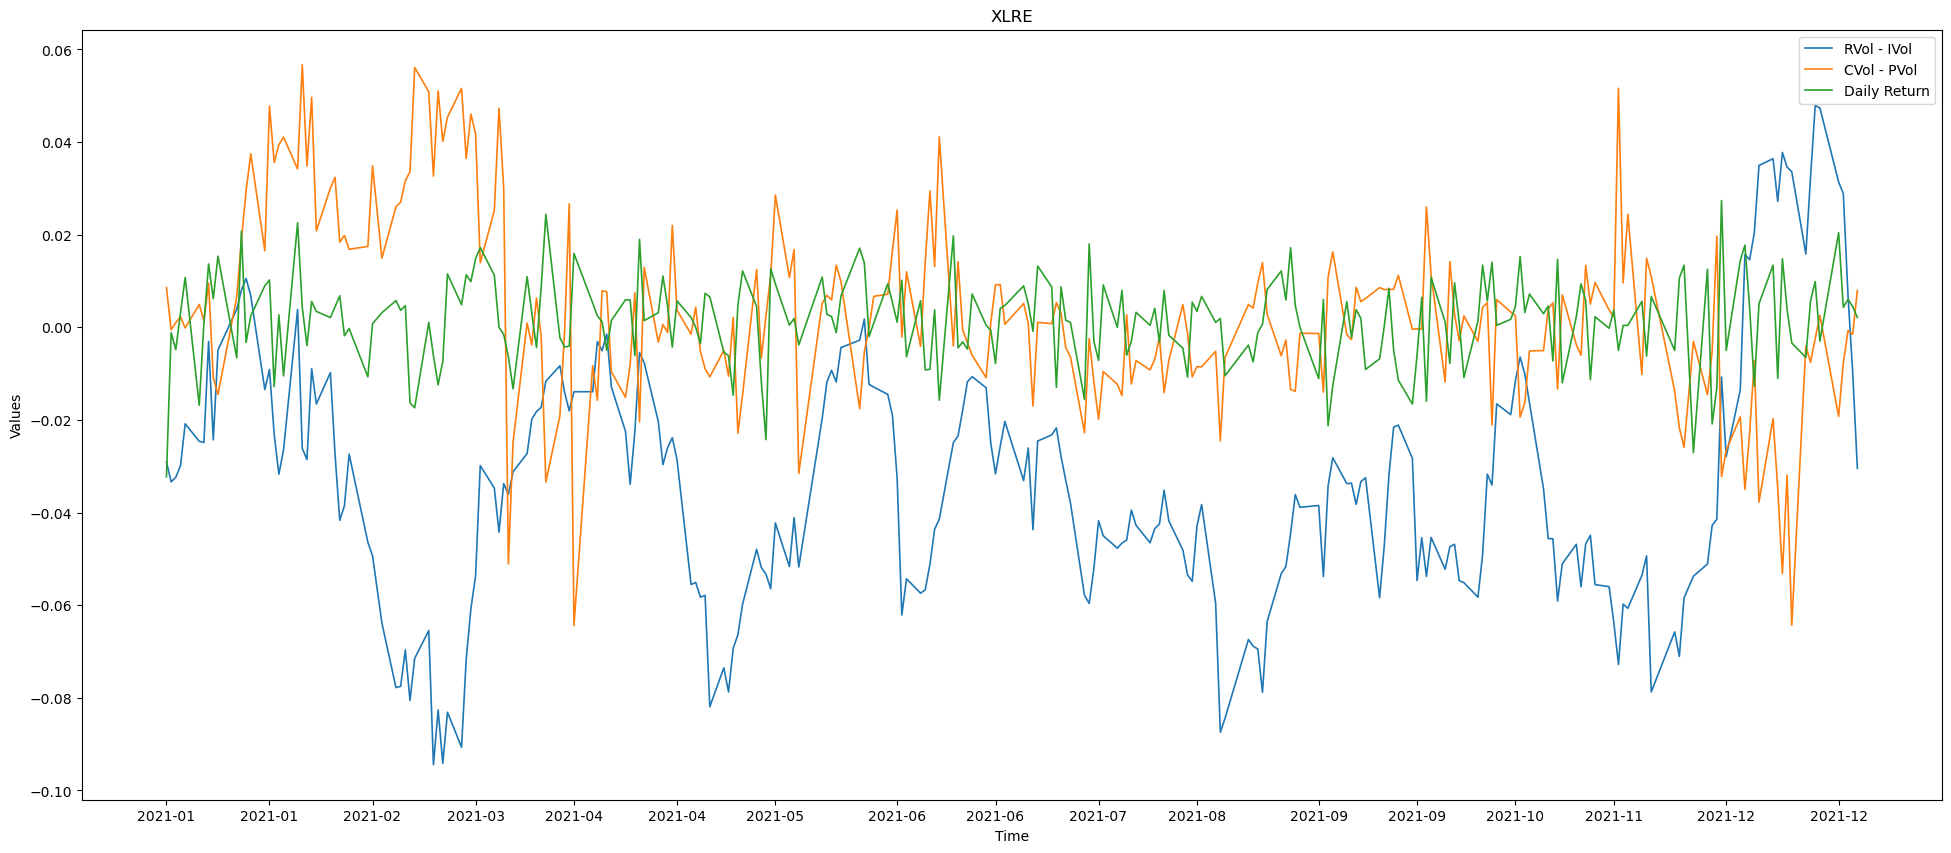

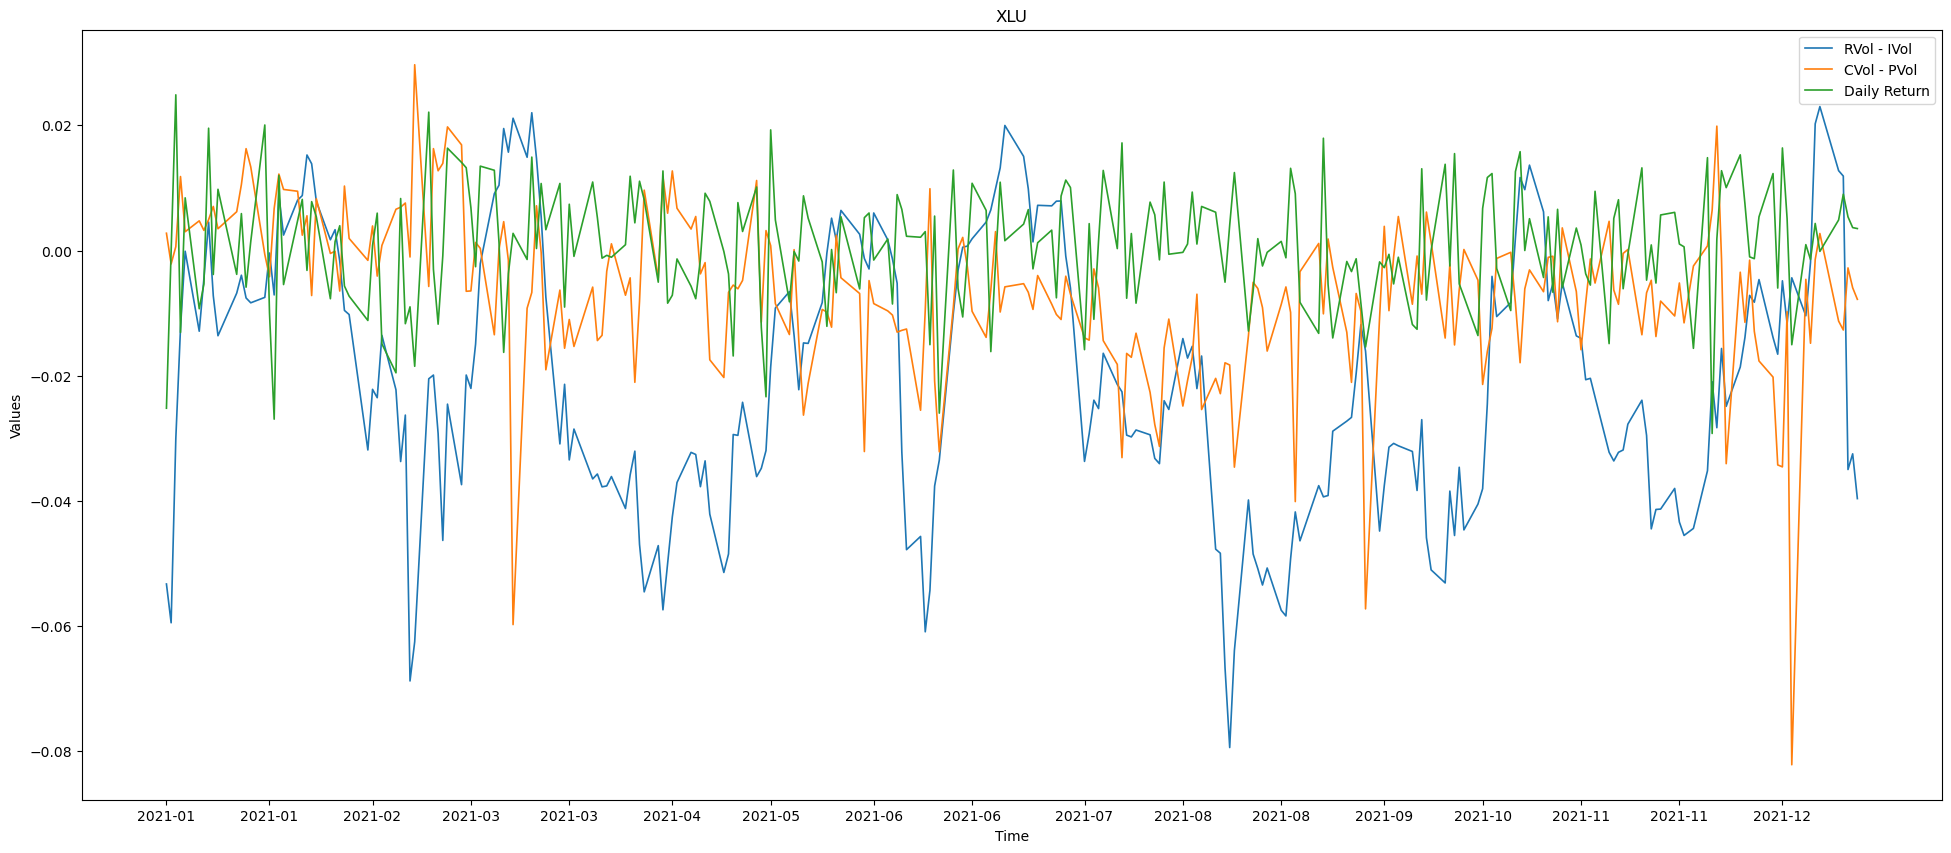

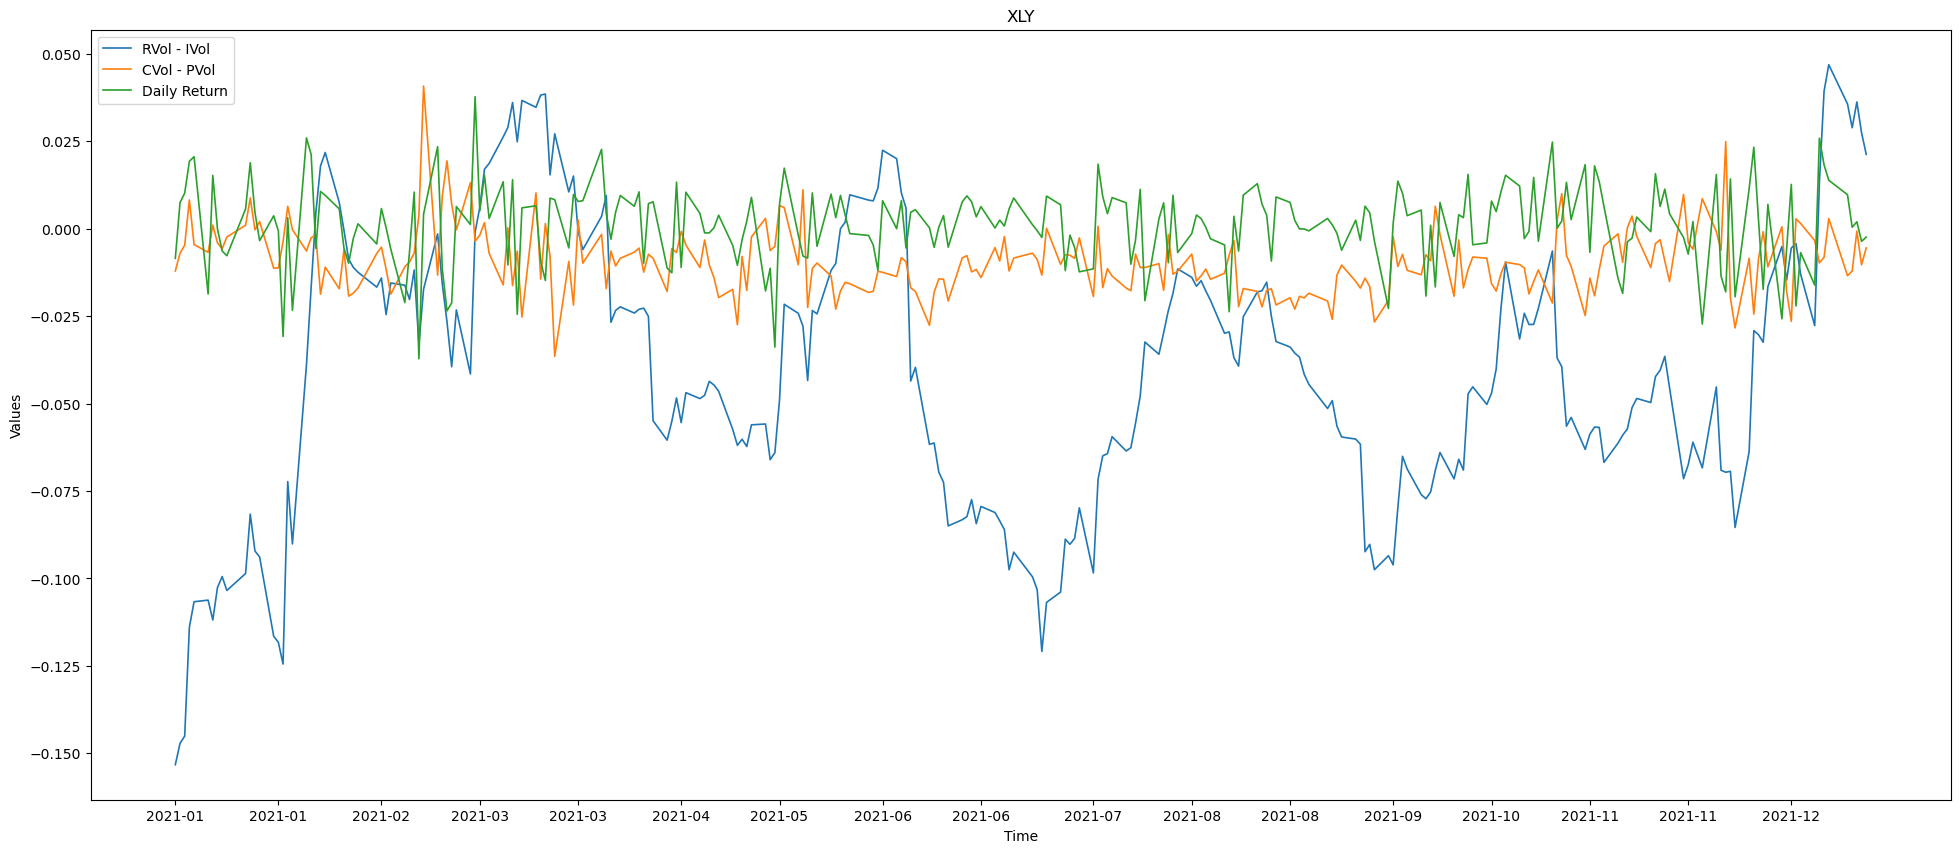

In [26]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

ticker_list = df['ticker'].unique()

for ticker in ticker_list:
    sub_df = df[df['ticker'] == ticker]
    sub_df.set_index('date', inplace=True)
    plt.figure(figsize=(24, 10))
    RmI = sub_df['RV-IV'].values
    CmP = sub_df['CV-PV'].values
    ret = sub_df['ret'].values

    plt.plot(sub_df.index, RmI, label='RVol - IVol', linewidth=1.2)
    plt.plot(sub_df.index, CmP, label='CVol - PVol', linewidth=1.2)
    plt.plot(sub_df.index, ret, label='Daily Return', linewidth=1.2)
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.title(f'{ticker}')

    # 設置橫軸刻度的間隔
    plt.xticks(sub_df.index[::15])
    # 設置橫軸日期格式
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

    plt.show()